# <center> <img src=https://upload.wikimedia.org/wikipedia/commons/e/e3/Booking.com_logo2.png style="width:400px;">

## <center> PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

****
**ОПИСАНИЕ ПРОБЛЕМЫ**  
Одна из проблем компании Booking — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить. Необходимо создать такую модель.

**ОПИСАНИЕ ДАННЫХ**


hotel_address — адрес отеля;  
review_date — дата, когда рецензент разместил соответствующий отзыв;  
average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;  
hotel_name — название отеля;  
reviewer_nationality — страна рецензента;  
negative_review — отрицательный отзыв, который рецензент дал отелю;  
review_total_negative_word_counts — общее количество слов в отрицательном отзыв;  
positive_review — положительный отзыв, который рецензент дал отелю;  
review_total_positive_word_counts — общее количество слов в положительном отзыве;  
reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;  
total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;  
total_number_of_reviews — общее количество действительных отзывов об отеле;  
tags — теги, которые рецензент дал отелю;  
days_since_review — количество дней между датой проверки и датой очистки;  
additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;  
lat — географическая широта отеля;  
lng — географическая долгота отеля.
****

### ПОДКЛЮЧАЕМ БИБЛИОТЕКИ

In [1260]:
#Инсталлируем модуль geopy для работы с координатами
#pip install geopy 

In [1261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from collections import Counter
from functools import partial
import datetime

# для нормализации, стандартизации
from sklearn import preprocessing

# для кодирования признаков
import category_encoders as ce

# для разбивки выборки на обучающую и тестовую  
from sklearn.model_selection import train_test_split  

# для работы с моделью  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# для работы с географическими координатами
from geopy.geocoders import Nominatim
import geopy.distance

# для работы с эмоциональной оценкой текстовых отзывов
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
#nltk.downloader.download('vader_lexicon')

# для оценки значимости 
from sklearn.feature_selection import chi2 # хи-квадрат. Для оценки значимости категориальных переменных
from sklearn.feature_selection import f_classif # anova. Для оценки значимости непрерывных переменных


****

#### ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ

##### ЧТЕНИЕ ДАННЫХ И АНАЛИЗ СТРУКТУРЫ

In [1262]:
hotels_train = pd.read_csv('data\hotels_train.csv') 
hotels_test = pd.read_csv('data\hotels_test.csv')
submission = pd.read_csv('data\submission.csv')

target_name = 'reviewer_score' # целевая переменная


In [1263]:
hotels_train.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [1264]:
hotels_test.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102


In [1265]:
display(submission.head(3))
print(submission.shape)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


(128935, 2)


In [1266]:
hotels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [1267]:
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

Пропуски есть в колонках lat и lng как в тренировочном, так и в тестовом датафреймах

****

#### ОБЪЕДИНЯЕМ ТРЕНИРОВОЧНЫЙ И ТЕСТОВЫЙ НАБОРЫ

In [1268]:
hotels_test[target_name] = np.nan
hotels_train['sample'] = 'train'
hotels_test['sample'] = 'test'
hotels_total = pd.concat([hotels_train,hotels_test])
print(f'Проверка: {hotels_train.shape[0] + hotels_test.shape[0]} = {hotels_total.shape[0]}')
display(hotels_total.head(3))
display(hotels_total.tail(3))

Проверка: 515738 = 515738


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,train
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,train
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,train


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
128932,Wiedner Hauptstra e 44 04 Wieden 1040 Vienna A...,260,7/6/2017,8.0,Suite Hotel 900 m zur Oper,New Zealand,No coffee in complimentary coffee in the room...,31,3461,The size of the room the courtyard and the lo...,23,1,NaN,"[' Business trip ', ' Solo traveler ', ' Singl...",28 days,48.193523,16.366915,test
128933,Corso Concordia 1 Milan City Center 20129 Mila...,159,12/26/2015,9.0,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,7,NaN,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586 day,45.468236,9.207380,test
128934,202 rue de Rivoli 1st arr 75001 Paris France,297,12/23/2015,8.0,Saint James Albany Paris Hotel Spa,United Kingdom,rooms were very dated and old fashion,8,2868,No Positive,0,1,NaN,"[' Leisure trip ', ' Couple ', ' Standard Room...",589 day,48.864269,2.330818,test


#### ПЕРЕВОДИМ ДАТУ В ФОРМАТ DATETIME

In [1269]:
hotels_total['review_date'] = pd.to_datetime(hotels_total['review_date'], format='%m/%d/%Y')

##### ЧИСЛОВЫЕ КОЛОНКИ

In [1270]:
# Выбираем столбцы с числовыми значениями
number_cols = hotels_total.select_dtypes(include = "number").columns
hotels_total[number_cols].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,386803.000000,512470.000000,512470.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,8.396906,49.442439,2.823803
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,1.636090,3.466325,4.579425
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214662,-0.143372
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.010607
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


##### lat, lng

In [1271]:
# Данные признаки содержат пропуски. Посмотрим внимательне
mask = (hotels_total['lat'].isnull()) | (hotels_total['lng'].isnull())
no_coord = hotels_total[mask]['hotel_address'].value_counts().index
print(f'Число отелей без координат: {len(no_coord)}')
print(f'Список отелей без координат: {no_coord}')

Число отелей без координат: 17
Список отелей без координат: Index(['Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'Pau Clar s 12

In [1272]:
# Проверим, есть ли координаты этих отелей в других отзывах

mask = (hotels_total['lat'].isnull()) | (hotels_total['lng'].isnull())
yes_coord = hotels_total[~mask]['hotel_address'].value_counts().index

no_yes = set(no_coord).intersection(set(yes_coord))
print(f'Кооличество отелей без координат, у которых указаны координаты в других отзывах: {len(no_yes)}')

Кооличество отелей без координат, у которых указаны координаты в других отзывах: 0


In [1273]:
# Пробуем найти координаты через бесплатный гео сервис Nominantum 
geolocator = Nominatim(user_agent="https")
geocode = partial(geolocator.geocode, language="es")
find_coord = pd.DataFrame(no_coord, columns = ['address'])

find_coord['location'] = find_coord['address'].apply(lambda x: geocode(x.split()[-4:]))
find_coord['lat'] = find_coord['location'].apply(lambda x: x.point[0])
find_coord['lng'] = find_coord['location'].apply(lambda x: x.point[1])
find_coord


,address,location,lat,lng
0,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,"(Josefstadt, Viena, 1080, Austria, (48.2105982...",48.210598,16.351750
1,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,"(Leopoldstadt, Viena, 1020, Austria, (48.20063...",48.200638,16.426895
2,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,"(KG Alsergrund, Alsergrund, Viena, 1090, Austr...",48.225073,16.358398
3,4 rue de la P pini re 8th arr 75008 Paris France,"(Union Locale CGT 18e arr. Paris, 42, Rue de C...",48.887022,2.347832
4,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,"(E, 1, Anton-von-Webern-Platz, Botschaftsviert...",48.202547,16.384616
5,W hringer Stra e 12 09 Alsergrund 1090 Vienna ...,"(KG Alsergrund, Alsergrund, Viena, 1090, Austr...",48.225073,16.358398
6,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,"(Ottakring, Viena, 1160, Austria, (48.2149546,...",48.214955,16.302153
7,Sieveringer Stra e 4 19 D bling 1190 Vienna Au...,"(Bling My Phone, Führichgasse, Kärntner Vierte...",48.204835,16.370208
8,Bail n 4 6 Eixample 08010 Barcelona Spain,"(Eixample, Barcelona, Barcelonés, Barcelona, C...",41.393689,2.163655
9,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,"(KG Alsergrund, Alsergrund, Viena, 1090, Austr...",48.225073,16.358398


In [1274]:
# Сервис нашел все районы и координаты
# Заполняем пропущенные значения

hotels_total['lat'] = hotels_total.apply(lambda x: find_coord[find_coord['address'] == x['hotel_address']]['lat'].iloc[0] if np.isnan(x['lat']) else x['lat'], axis =1)
hotels_total['lng'] = hotels_total.apply(lambda x: find_coord[find_coord['address'] == x['hotel_address']]['lng'].iloc[0] if np.isnan(x['lng']) else x['lng'], axis =1)
hotels_total[['lat', 'lng']].isnull().sum()


lat    0
lng    0
dtype: int64

Дальнейшую работу с координатами продолжим после получения признака города отеля

##### СТРОКОВЫЕ КОЛОНКИ

In [1275]:
# Выбираем столбцы со строковыми значениями
notnumber_cols = hotels_total.select_dtypes(exclude = "number").columns
exclude_cols = ['review_date']
notnumber_cols = list(filter(lambda x: x not in exclude_cols, notnumber_cols))
hotels_total[notnumber_cols].describe()

,hotel_address,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review,sample
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,1492,227,330011,412601,55242,731,2
top,163 Marsh Wall Docklands Tower Hamlets London ...,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,train
freq,4789,4789,245246,127890,35946,5101,2585,386803


*****
БЛОК ОПРЕДЕЛЕНИЯ ФУНКЦИЙ ДЛЯ РАБОТЫ СО СТРОКОВЫМИ КОЛОНКАМИ

In [1276]:
def get_object_col_info(df, col, n_top = 10):
    #Функция возвращает статистику по строковой колонке df[col]
    # n_top: число наиблее часто встречающихся значений
    n_unique = df[col].nunique()
    n = df.shape[0]
    na_cnt = df[col].isnull().sum()
    not_na_cnt = n - na_cnt     
    print(f'Колонка {col}')
    print(f'Количество пропусков: {na_cnt} из {n} строк ({na_cnt/n *100:.2f}%))')
    print(f'Количество уникальных значений: {n_unique} из {not_na_cnt} непустых значений ({n_unique/not_na_cnt *100:.2f}%)')
    print('-'*50)
    print(f'Топ {n_top} наиболее часто встрещающихся значений, %:\n')
    top = round(df[col].value_counts(normalize=True).nlargest(n_top)*100, 1)
    print(top)
    print('-'*50)
    print(f'Топ {n_top} наименее часто встрещающихся значений, %:\n')
    top = round(df[col].value_counts(normalize=True).nsmallest(n_top)*100, 1)
    print(top)

In [1277]:
def get_object_chart(df, col, target):
    #Функция выводит графическую информцию о значениях target 
    #в разрезе значений колонки col в датафрейме df
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
    
    sns.countplot(
        data=df,
        x=col,
        ax=axes[0][0]
    )
    axes[0][0].set_title(f'Количество отзывов по {col}', fontsize=12)
    axes[0][0].bar_label(axes[0][0].containers[0])
        
    
    sns.barplot(
        data=df,
        x=col,
        y=target_name,
        errwidth=0,
        ax=axes[0][1]
    )
    axes[0][1].set_title(f'Среднее значение {target_name} по {col}', fontsize=12)
    axes[0][1].set_ylim([0,10])
    axes[0][1].bar_label(axes[0][1].containers[0], fmt='%.1f')
    
    
    sns.histplot(
        data=df,
        x=target,
        bins=10,
        ax=axes[1][0]
    );
    axes[1][0].set_title(f'Гистограмма распределения {target}', fontsize=12)
    sns.boxplot(
        data=df,
        x=target,
        y=col,
        orient='h',
        showmeans=True,
        ax=axes[1][1]
    );
    axes[1][1].set_title(f'Распределение {target} по {col}', fontsize=12)
    axes[1][1].set_ylabel(None)

In [1278]:
def get_list_value(str_val , lst, ifnone = 'other'):
    #Функция проверет есть ли в строке str_val значение из списка lst
    #Если есть, то возвращает найденое значение, если нет - то возвращает ifnone
    
    str_val = str_val.lower()
    for val in lst:
        val = val.lower()
        search_val = r'\b' + val
        pattern = re.compile(search_val)
        match = re.search(pattern, str_val)
        if match:
            return val
    return ifnone

In [1279]:
def onehotcoding(df, col, feature_lst):
    #Функция проводит one hot coding колонки col из датафрейма df 
    #на основании списка feature_lst
    feature_cols = list()
    for feature in feature_lst:
        feature_cols.append('is_' + col + '_' + feature.replace(' ','').lower())
        df['is_' + col + '_' + feature.replace(' ','').lower()] = df[col].apply(lambda x: 1 if feature in x else 0)
    
    return feature_cols

*****

#### hotel_address

In [1280]:
col = 'hotel_address'
get_object_col_info(hotels_total, col, n_top=10)

Колонка hotel_address
Количество пропусков: 0 из 515738 строк (0.00%))
Количество уникальных значений: 1493 из 515738 непустых значений (0.29%)
--------------------------------------------------
Топ 10 наиболее часто встрещающихся значений, %:

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              0.9
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     0.8
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     0.8
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    0.7
7 Pepys Street City of London London EC3N 4AF United Kingdom                      0.6
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom              0.6
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom                  0.5
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                 0.5
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH Unite

Пропусков нет. Много уникальных адресов (1 493). Выделяем из адреса город и страну.

In [1281]:
# Функция возвращающая кортеж (страна, город) из адреса отеля
def get_country_city(row):
    lst = row.split()
    if lst[-1] == 'Kingdom':
        return ' '.join(lst[-2:]), lst[-5]
    else:
        return lst[-1], lst[-2]

In [1282]:
# Выделяем страну и город
hotels_total['country'], hotels_total['city'] = zip(*hotels_total[col].map(get_country_city))
print(hotels_total['country'].value_counts().index)
print(hotels_total['city'].value_counts().index)


Index(['United Kingdom', 'Spain', 'France', 'Netherlands', 'Austria', 'Italy'], dtype='object')
Index(['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan'], dtype='object')


In [1283]:
hotels_total[['country' , 'city']].value_counts().index

MultiIndex([('United Kingdom',    'London'),
            (         'Spain', 'Barcelona'),
            (        'France',     'Paris'),
            (   'Netherlands', 'Amsterdam'),
            (       'Austria',    'Vienna'),
            (         'Italy',     'Milan')],
           names=['country', 'city'])

Количество полученных стран и городов позволяет рассматривать их как признаки для будущей модели. В анализируемом датафрейме в каждой стране только один город, поэтому в дальнейшем один из принаков можно удалить. Пока оставим для уточнения координат центра города, которые будут нужны для расчета расстояния от центра до отеля.

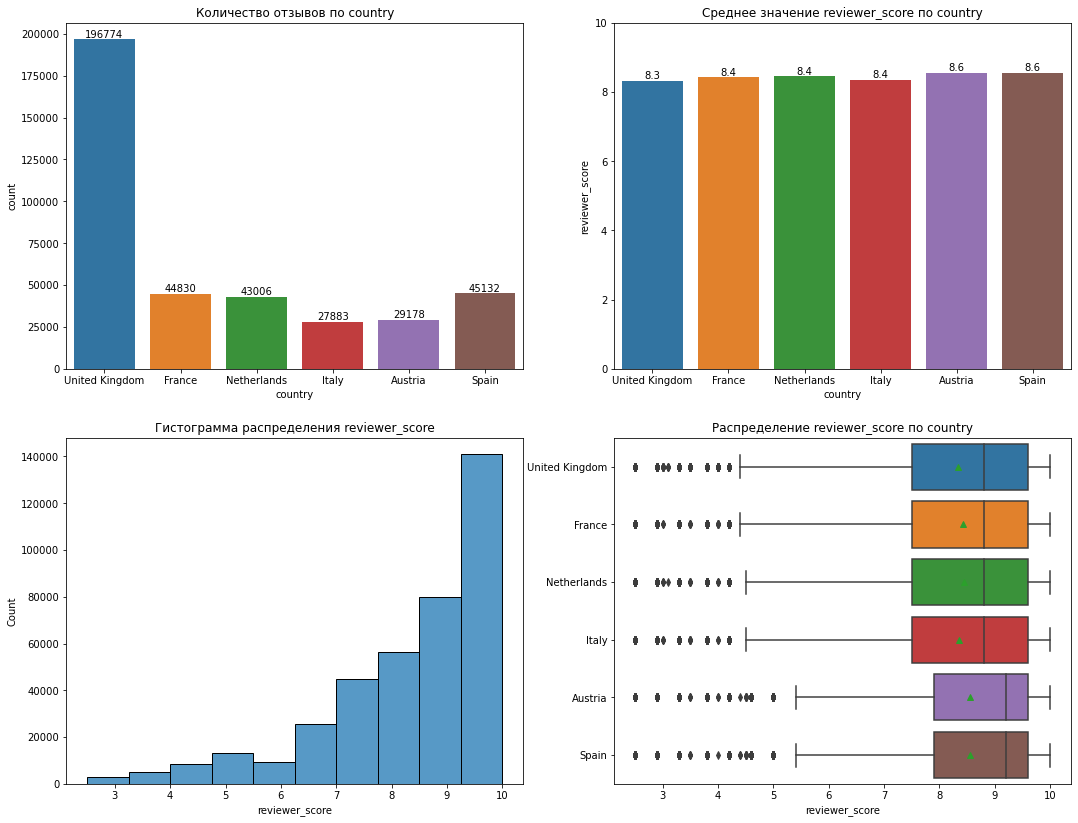

In [1284]:
# Построим графики
mask = hotels_total['sample'] == 'train'
col = 'country'
get_object_chart(hotels_total[mask], col, target_name)

In [1285]:
# Формируем one hot coding признаки
feature_lst = list(hotels_total['country'].unique())
new_cols = onehotcoding(hotels_total, 'country', feature_lst)
hotels_total[new_cols].sum()

is_country_unitedkingdom    262301
is_country_france            59928
is_country_netherlands       57214
is_country_italy             37207
is_country_austria           38939
is_country_spain             60149
dtype: int64

In [1286]:
# Вернемся к координатам и расчету расстояния до центра города

hotels_cities = hotels_total[['country' , 'city']].value_counts().index
hotels_cities = pd.DataFrame(hotels_cities, columns = ['city'])
hotels_cities['location'] = hotels_cities['city'].apply(lambda x: geocode(x))
hotels_cities ['lat'] = hotels_cities['location'].apply(lambda x: x.point[0])
hotels_cities ['lng'] = hotels_cities['location'].apply(lambda x: x.point[1])
hotels_cities['city'] = hotels_cities['city'].apply(lambda x: x[1])
hotels_cities
 

,city,location,lat,lng
0,London,"(Londres, Greater London, Inglaterra, Reino Un...",51.507322,-0.127647
1,Barcelona,"(Barcelona, Barcelonés, Barcelona, Cataluña, 0...",41.382894,2.177432
2,Paris,"(París, Isla de Francia, Francia metropolitana...",48.858890,2.320041
3,Amsterdam,"(Ámsterdam, Amsterdam, Holanda Septentrional, ...",52.372760,4.893604
4,Vienna,"(Viena, 1010, Austria, (48.2083537, 16.3725042))",48.208354,16.372504
5,Milan,"(Milán, Lombardía, Italia, (45.4641943, 9.1896...",45.464194,9.189635


In [1287]:
def distance_to_center(city, lat, lng):
    # Функция вычисляет расстояние до центра города city от точки с координатами lat, lng
    city_lat = hotels_cities[hotels_cities['city'] == city]['lat'].iloc[0]
    city_lng = hotels_cities[hotels_cities['city'] == city]['lng'].iloc[0]

    return geopy.distance.geodesic([city_lng, city_lat], [lng, lat]).km


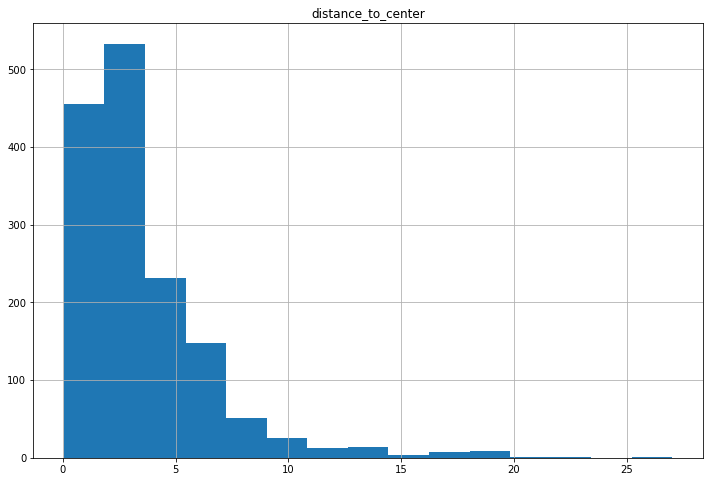

In [1288]:
hotels_unique = hotels_total[['hotel_address', 'hotel_name', 'lat' , 'lng', 'city']].drop_duplicates()
hotels_unique['distance_to_center'] = hotels_unique.apply(lambda x: distance_to_center(x['city'], x['lat'], x['lng']), axis = 1)

hotels_unique.hist(column = 'distance_to_center' , bins = 15, figsize=(12,8));


In [1289]:
# Добавляем признак distance_to_center к каждому отзыву

hotels_total = hotels_total.merge(hotels_unique, on = ['hotel_address' , 'hotel_name' , 'lat' , 'lng'], how = 'left') 

In [1290]:
hotels_total.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'country', 'city_x',
       'is_country_unitedkingdom', 'is_country_france',
       'is_country_netherlands', 'is_country_italy', 'is_country_austria',
       'is_country_spain', 'city_y', 'distance_to_center'],
      dtype='object')

In [1291]:
hotels_total = hotels_total.drop('city_x', axis = 1) # удаляем признак город
hotels_total = hotels_total.drop('city_y', axis = 1) # удаляем признак город
hotels_total = hotels_total.drop('lat', axis = 1) # удаляем признак широты
hotels_total = hotels_total.drop('lng', axis = 1) # удаляем признак широты
hotels_total = hotels_total.drop('hotel_address', axis = 1) # удаляем исходный признак

#### hotel_name

In [1292]:
col = 'hotel_name'
get_object_col_info(hotels_total, col, n_top=10)

Колонка hotel_name
Количество пропусков: 0 из 515738 строк (0.00%))
Количество уникальных значений: 1492 из 515738 непустых значений (0.29%)
--------------------------------------------------
Топ 10 наиболее часто встрещающихся значений, %:

Britannia International Hotel Canary Wharf           0.9
Strand Palace Hotel                                  0.8
Park Plaza Westminster Bridge London                 0.8
Copthorne Tara Hotel London Kensington               0.7
DoubleTree by Hilton Hotel London Tower of London    0.6
Grand Royale London Hyde Park                        0.6
Holiday Inn London Kensington                        0.5
Hilton London Metropole                              0.5
Millennium Gloucester Hotel London                   0.5
Intercontinental London The O2                       0.5
Name: hotel_name, dtype: float64
--------------------------------------------------
Топ 10 наименее часто встрещающихся значений, %:

Hotel Gallitzinberg                       0.0
Hotel Wa

In [1293]:
# Зададим крупные сетевые отели, остальные обозначим как other

networks = ['Marriott', 'Hilton', 'Hyatt', 'Ritz', 'Holiday', 'Accor', \
    'Best Western', 'Banyan', 'Four Seasons', 'Rixos', 'Sheraton', 'Mandarin', 'Regis', 'W Hotel', 'Choice',  \
    'InterContinental', 'Radisson', 'Sofitel', 'Westin', 'Meridien', 'Novotel' , 'Kempinski', 
    ]

hotels_total['network'] = hotels_total[col].apply(lambda x: get_list_value(x, networks))
hotels_total['network'].value_counts()

other               409207
hilton               35490
best western         16260
holiday              15874
radisson             11250
novotel               9838
marriott              6316
sofitel               3221
intercontinental      3082
hyatt                 1933
ritz                  1207
meridien               768
sheraton               334
westin                 289
four seasons           256
mandarin               217
kempinski              196
Name: network, dtype: int64

Сетевых отелей по отдельности получилось не очень много, поэтому сделаем признак сетевой и other

In [1294]:
hotels_total['network'] = hotels_total['network'].apply(lambda x: 0 if x == 'other' else 1)

In [1295]:
hotels_total = hotels_total.drop('hotel_name', axis = 1) # удаляем признак название отеля

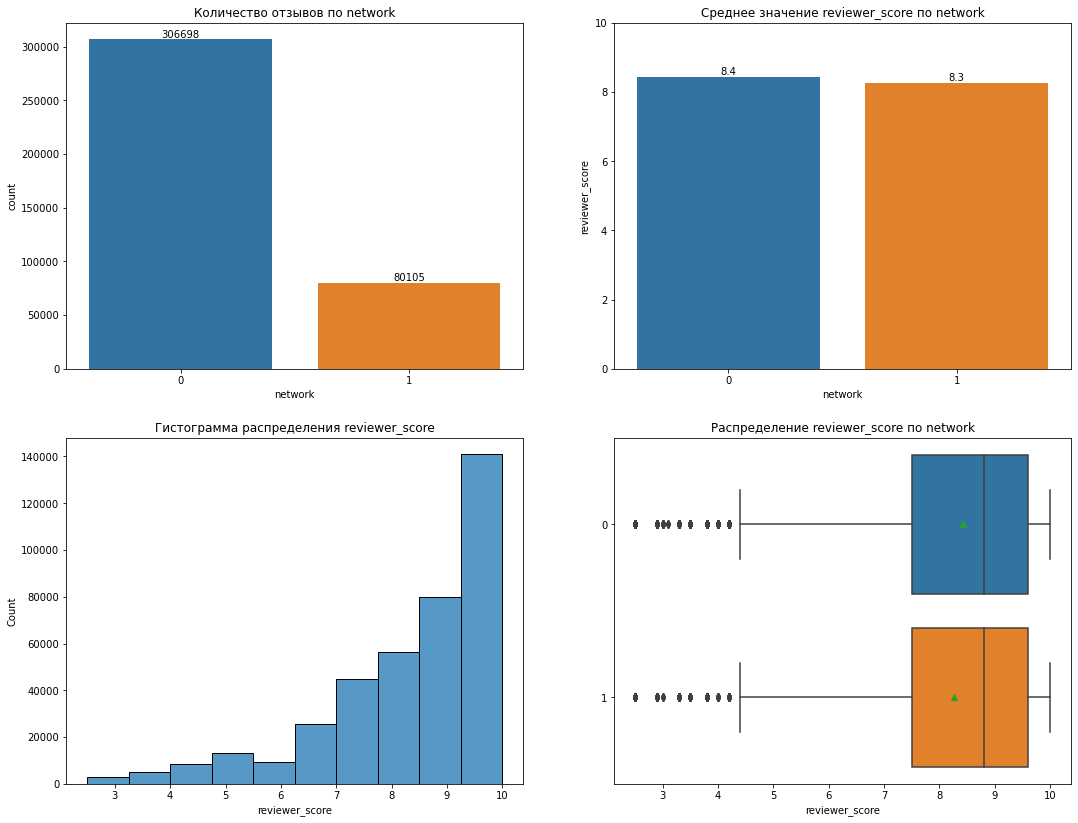

In [1296]:
# Построим графики
mask = hotels_total['sample'] == 'train'
col = 'network'
get_object_chart(hotels_total[mask], col, target_name)

*****

#### reviewer_nationality

In [1297]:
col = 'reviewer_nationality'
get_object_col_info(hotels_total, col, n_top=10)

Колонка reviewer_nationality
Количество пропусков: 0 из 515738 строк (0.00%))
Количество уникальных значений: 227 из 515738 непустых значений (0.04%)
--------------------------------------------------
Топ 10 наиболее часто встрещающихся значений, %:

 United Kingdom               47.6
 United States of America      6.9
 Australia                     4.2
 Ireland                       2.9
 United Arab Emirates          2.0
 Saudi Arabia                  1.7
 Netherlands                   1.7
 Switzerland                   1.7
 Germany                       1.5
 Canada                        1.5
Name: reviewer_nationality, dtype: float64
--------------------------------------------------
Топ 10 наименее часто встрещающихся значений, %:

 Vatican City                 0.0
 Palau                        0.0
 Svalbard Jan Mayen           0.0
 Northern Mariana Islands     0.0
 Guinea                       0.0
 Tuvalu                       0.0
 Comoros                      0.0
 Anguilla        

Достаточно много уникальных значений. Явное преимущество за англичанами. 
Сделаем бинарный признак англичане и не англичане. Но перед этим создадим признак соответвует ли национальность 
стране, где находится отель 

In [1298]:
hotels_total['is_local'] = hotels_total.apply(lambda x: 1 if x['reviewer_nationality'].replace(' ','') == x['country'].replace(' ','') else 0, axis=1)

In [1299]:
hotels_total['is_nationality_uk'] = hotels_total['reviewer_nationality'].apply(lambda x: 1 if x.lower().replace(' ','') == 'unitedkingdom' else 0)

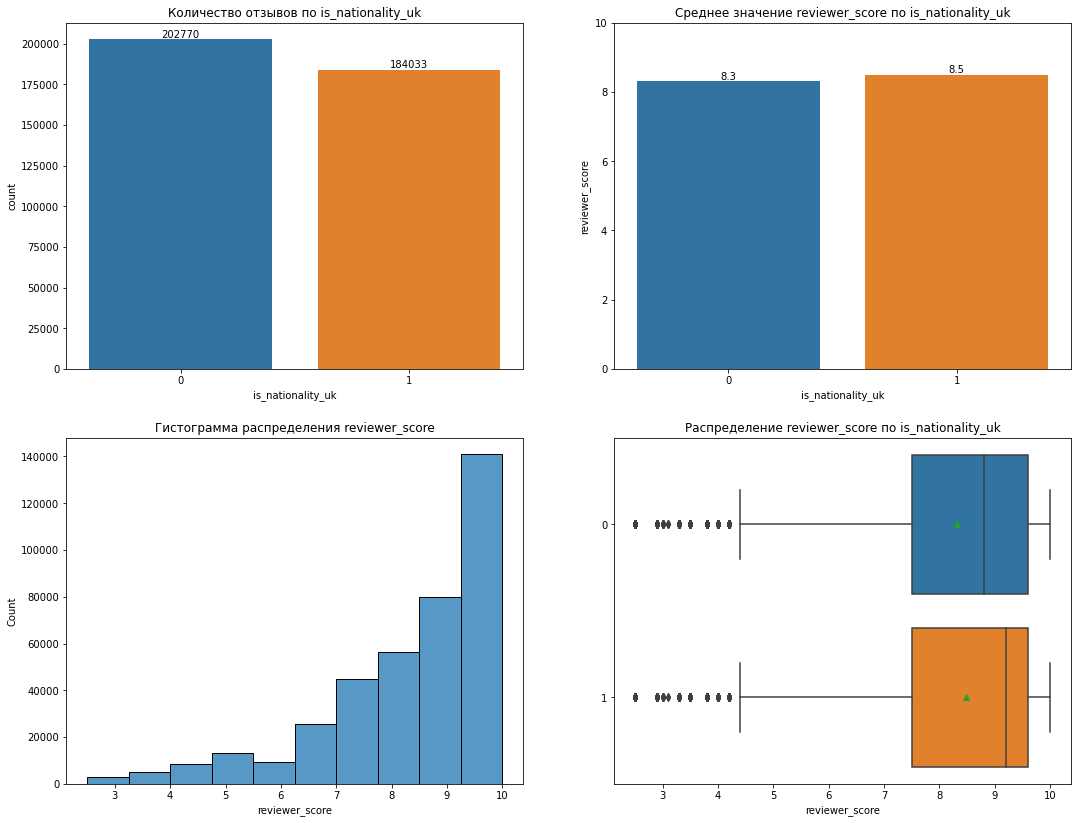

In [1300]:
# Построим графики 
mask = hotels_total['sample'] == 'train'
col = 'is_nationality_uk'
get_object_chart(hotels_total[mask], col, target_name)

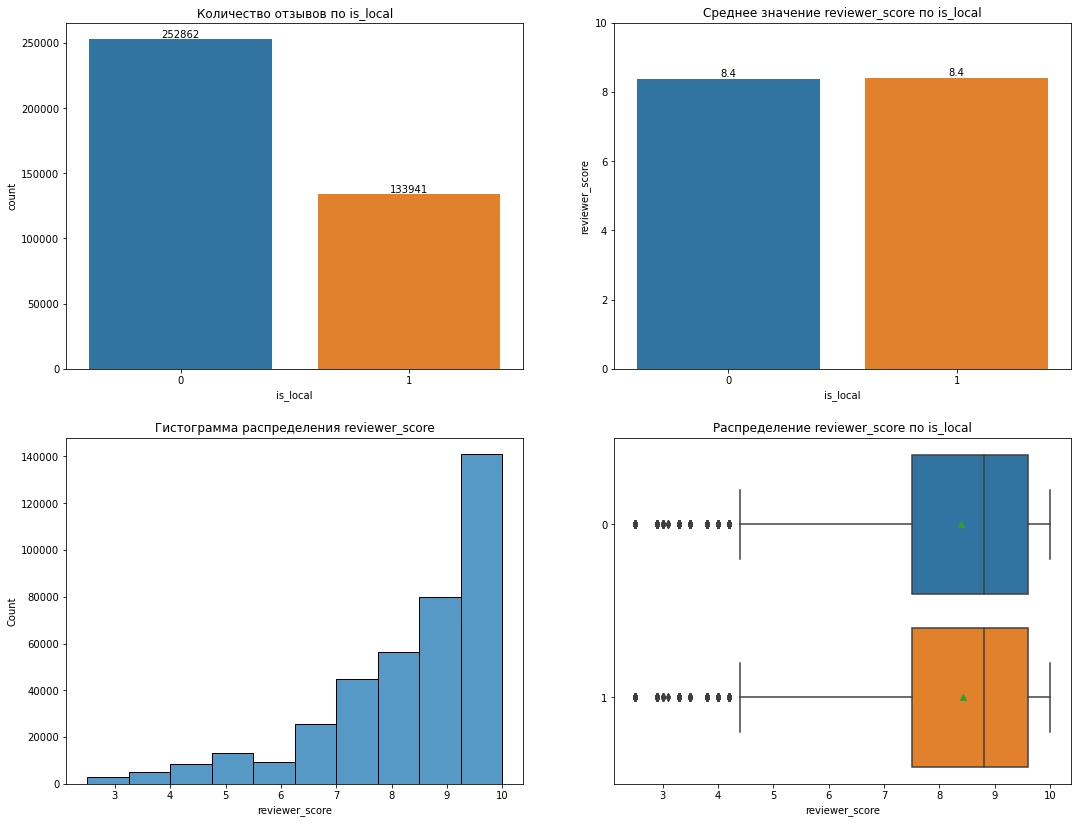

In [1301]:
# Построим графики 
mask = hotels_total['sample'] == 'train'
col = 'is_local'
get_object_chart(hotels_total[mask], col, target_name)

In [1302]:
hotels_total = hotels_total.drop('reviewer_nationality', axis = 1) # удаляем признак национальности
hotels_total = hotels_total.drop('country', axis = 1) # удаляем признак country

****

#### negative_review, positive_review

In [1303]:
# На основании этих колонок посчитаем 2 признака
# Разница количества слов между позитивным и негативным отзывами
# Оценка эмоциональности  

#Подготавливаем данные - переводим в нижний регистр и убираем пробелы в начале и конце
hotels_total['positive_review'] = hotels_total['positive_review'].str.lower().str.strip()
hotels_total['negative_review'] = hotels_total['negative_review'].str.lower().str.strip()
# Убираем No Negative и No Positive и добавляем соответствующие признаки
hotels_total['no_positive'] = hotels_total['positive_review'].apply(lambda x: 1 if ('no positive' in x or 'nothing' in x) else 0)
hotels_total['positive_review'] = hotels_total['positive_review'].apply(lambda x: x if x != 'no positive' else ' ')

hotels_total['no_negative'] = hotels_total['negative_review'].apply(lambda x: 1 if 'no negative' in x else 0)
hotels_total['negative_review'] = hotels_total['negative_review'].apply(lambda x: x if x != 'no negative' else ' ')


In [1304]:
# Уточнение числа слов в позитивном и негативном отзывах

hotels_total['review_total_positive_word_counts'] = hotels_total['positive_review'].apply(lambda x: len(x.split()))
hotels_total['review_total_negative_word_counts'] = hotels_total['negative_review'].apply(lambda x: len(x.split()))
hotels_total['pos_neg_diff'] = hotels_total['review_total_positive_word_counts'] - hotels_total['review_total_negative_word_counts']

In [1305]:
# Попробуем выделить высокие оценки за счет слов в превосходной степени
mask = hotels_total[target_name] == hotels_total[target_name].max()
pos_lst = hotels_total[mask]['positive_review'].to_list()
pos_str = ' '.join(pos_lst)
cnt = Counter(pos_str.split())
most_common_lst = list(filter(lambda x: len(x[0]) > 4 , cnt.most_common(70)))
most_common_lst

[('staff', 44554),
 ('hotel', 31393),
 ('location', 30104),
 ('great', 23950),
 ('friendly', 18545),
 ('helpful', 16960),
 ('excellent', 15277),
 ('breakfast', 14959),
 ('clean', 12079),
 ('comfortable', 11145),
 ('everything', 10757),
 ('lovely', 8992),
 ('rooms', 8037),
 ('perfect', 7915),
 ('amazing', 7553),
 ('service', 7239),
 ('really', 6388),
 ('would', 5561),
 ('fantastic', 5076),
 ('again', 5016),
 ('there', 4753),
 ('close', 4522),
 ('beautiful', 4488),
 ('loved', 4130),
 ('station', 4043),
 ('comfy', 4029)]

In [1306]:
# Создаем список прилагательных

is_great_lst = [
    'great', 'friendly' , 'helpful', 'excellent', 'comfortable', 'lovely', 'perfect', 'amazing', 'fantastic', 'beautiful', 'loved'
] 

# Убираем негативный отзыв, если в позитивном были прилагательные в превосходной степени
hotels_total['negative_review'] = hotels_total.apply(lambda x: x['negative_review'] if get_list_value(x['positive_review'],is_great_lst) == 'other' else ' ', axis = 1)
# Добавляем новый признак, если в отзыве были позитивные прилагательные
hotels_total['was_great'] = hotels_total['positive_review'].apply(lambda x: 0 if get_list_value(x,is_great_lst) == 'other' else 1)




In [1307]:
# Эмоциональная оценка текста отзыва
sent_analyser = SentimentIntensityAnalyzer()

hotels_total['neg_scores'] = hotels_total['negative_review'].apply(lambda x: sent_analyser.polarity_scores(x))
hotels_total['pos_scores'] = hotels_total['positive_review'].apply(lambda x: sent_analyser.polarity_scores(x))

hotels_total.loc[:,['neg_neg_score', 'neg_pos_score', 'neg_compound_score']] = list(hotels_total['neg_scores'].apply(lambda x: [x['neg'], x['pos'], x['compound']]).values)
hotels_total.loc[:,['pos_neg_score', 'pos_pos_score', 'pos_compound_score']] = list(hotels_total['pos_scores'].apply(lambda x: [x['neg'], x['pos'], x['compound']]).values)

hotels_total['pos_neg_compound_diff'] = hotels_total['pos_compound_score'] + hotels_total['neg_compound_score'] # интегрирующая статистика

hotels_total = hotels_total.drop(['neg_scores','pos_scores'], axis = 1)


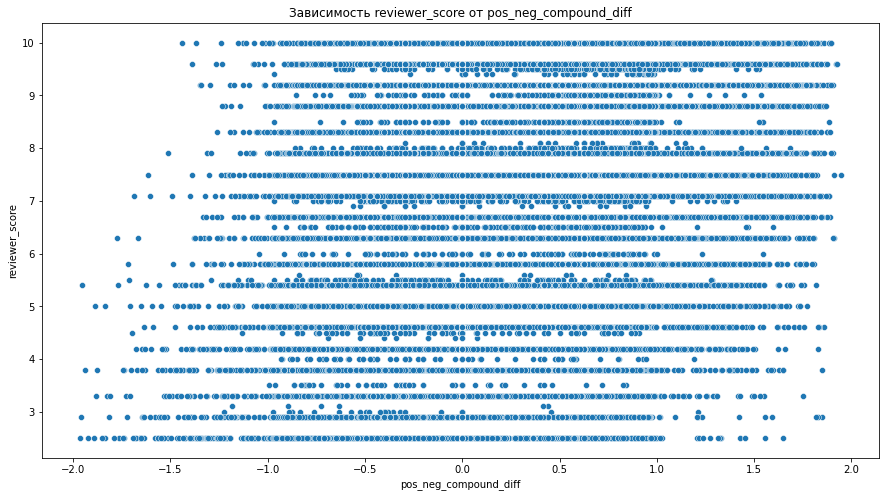

In [1308]:
fig, axes = plt.subplots(figsize=(15,8))

sns.scatterplot(
    data = hotels_total,
    x = 'pos_neg_compound_diff',
    y = target_name
)

axes.set_title(f'Зависимость {target_name} от pos_neg_compound_diff');


Видно, что pos_neg_compound_diff не очень хорошо объясняет выставленную оценку. Посмотрим как отработает в модели.

In [1309]:
# Удаляем отзывы и вспомогательный результат функции анализа эмоциональной оценки текста (оставляем только сводные [compound] результаты)
hotels_total = hotels_total.drop(['positive_review', 'negative_review', 'neg_neg_score', 'neg_pos_score', 'pos_neg_score', 'pos_pos_score'], axis = 1) # удаляем признаки отзывов

****

#### tags

In [1310]:
# Посчитаем уникальное число тэгов и количество их упоминаний
# В качестве признаков для модели выберем наиболее часто упоминаемые
col = 'tags'
print(f'Тип данных в колонке {col}: {type(hotels_total[col].iloc[0])}')

Тип данных в колонке tags: <class 'str'>


Несмотря на внешний вид, колонка с тэгами не список, а строка. Преобразуем в список

In [1311]:
hotels_total[col] = hotels_total[col].apply(lambda x: x[1:-1].replace("'", '').split(',')) # убираем скобки и кавычки, преобразуем в список
hotels_total[col] = hotels_total[col].apply(lambda x: list(map(lambda y: y.strip(), x ))) # убираем пробелы справа и слева

In [1312]:
tags = hotels_total[col].explode(col).value_counts(normalize=True)
print(f'Количество уникальных тэгов: {tags.shape[0]}')
tags = tags[:10]
tags

Количество уникальных тэгов: 2428


Leisure trip                      0.177281
Submitted from a mobile device    0.130544
Couple                            0.107059
Stayed 1 night                    0.082172
Stayed 2 nights                   0.056835
Solo traveler                     0.046060
Stayed 3 nights                   0.040661
Business trip                     0.035194
Group                             0.027749
Family with young children        0.025891
Name: tags, dtype: float64

In [1313]:
# Формируем признаки для наиболее часто упиминамых тэгов
feature_lst = list(tags.index)
new_cols = onehotcoding(hotels_total, 'tags', feature_lst)
hotels_total[new_cols].sum()


is_tags_leisuretrip                   417778
is_tags_submittedfromamobiledevice    307640
is_tags_couple                        252294
is_tags_stayed1night                  193645
is_tags_stayed2nights                 133937
is_tags_solotraveler                  108545
is_tags_stayed3nights                  95821
is_tags_businesstrip                   82939
is_tags_group                          65392
is_tags_familywithyoungchildren        61015
dtype: int64

In [1314]:
hotels_total = hotels_total.drop(['tags'], axis = 1) # удаляем признак тэгов

****

#### days_since_review

In [1315]:
col = 'days_since_review'
hotels_total[col].head(5)

0    531 day
1    203 day
2    289 day
3    681 day
4    516 day
Name: days_since_review, dtype: object

In [1316]:
#Оставим только цифры
pattern = re.compile(r'\d+')
hotels_total['days_since_review'] = hotels_total['days_since_review'].apply(lambda x: int(re.search(pattern, x)[0]))
min_days = hotels_total['days_since_review'].min()
max_days = hotels_total['days_since_review'].max()
mean_days = hotels_total['days_since_review'].mean()
print(f'Минимальное число дней: {min_days}')
print(f'Максимальное число дней: {max_days}')
print(f'Среднее число дней: {round(mean_days)}')

Минимальное число дней: 0
Максимальное число дней: 730
Среднее число дней: 354


****

#### review_date

In [1317]:
col = 'review_date'
final_date = hotels_total[col].max()
first_date = hotels_total[col].min()
print(f'Самая ранняя дата обзора: {first_date:%Y-%m-%d}')
print(f'Самая поздняя дата обзора: {final_date: %Y-%m-%d}')

Самая ранняя дата обзора: 2015-08-04
Самая поздняя дата обзора:  2017-08-03


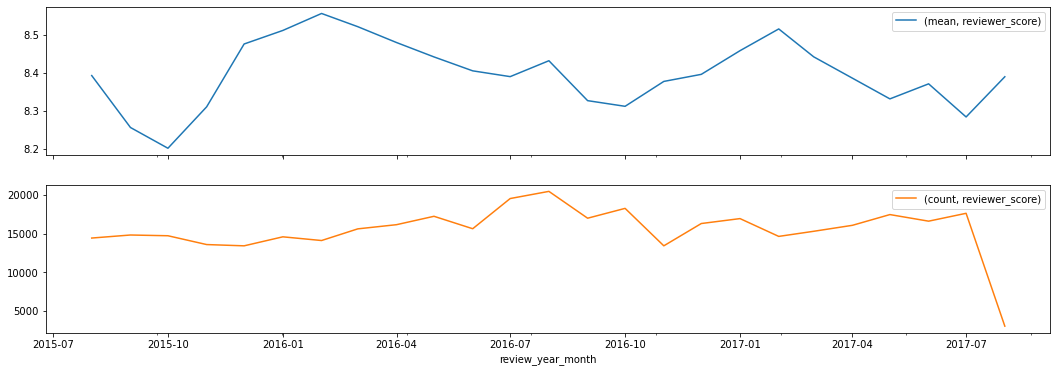

In [1318]:
# Добавляем признак количество дней до самой поздней даты, год-месяц

hotels_total['review_day'] = hotels_total['review_date'].apply(lambda x: (final_date - x).days)
hotels_total['review_year_month'] = hotels_total['review_date'].apply(lambda x: datetime.date(x.year,x.month,1))

# Посмотрим на график по месяцам
mask = hotels_total['sample'] == 'train'
pivot = pd.pivot_table(hotels_total[mask], index = 'review_year_month' , values = target_name, aggfunc = ['mean', 'count'])
pivot.plot(subplots = True, figsize=(18,6));

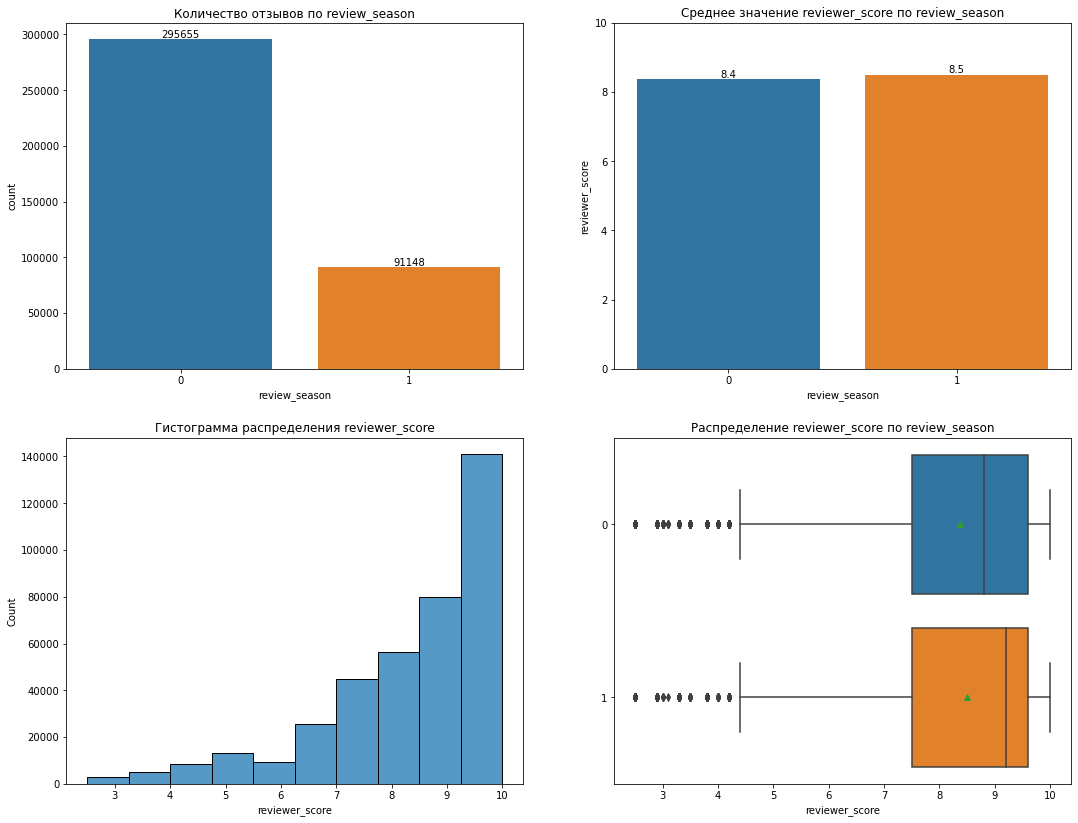

In [1319]:
# Судя по графику, есть рост в начале каждого года
# Сделаем признак сезона (1 - январь/февраль, 0 - остальные месяца)
hotels_total['review_season'] = hotels_total['review_date'].apply(lambda x: 1 if x.month in [1,2,3] else 0)

# Посмотрим, что получилось
mask = hotels_total['sample'] == 'train'
get_object_chart(hotels_total[mask], 'review_season',target_name)

In [1320]:
hotels_total[['review_day', 'days_since_review']].head(10)

,review_day,days_since_review
0,531,531
1,203,203
2,289,289
3,681,681
4,516,516
5,582,582
6,77,77
7,192,192
8,618,618
9,548,548


In [1321]:
# По первым строкам видно, что полученный признак review_day совпадает с days_since_review
# Проверим на всем датафрейме, посчитав разницу
days_diff = hotels_total['review_day'] - hotels_total['days_since_review']
days_diff.sum()

0

In [1322]:
# Колонки полностью совпадают - удаляем одну из них
hotels_total = hotels_total.drop(['days_since_review'], axis = 1) # удаляем признак 


In [1323]:
# Удалаяем признак review_date и review_year_month
hotels_total = hotels_total.drop(['review_date'], axis = 1)  
hotels_total = hotels_total.drop(['review_year_month'], axis = 1) 

****

##### ЧИСЛОВЫЕ КОЛОНКИ

****

БЛОК ОПРЕДЕЛЕНИЯ ФУНКЦИЙ ДЛЯ ЧИСЛОВЫХ КОЛОНОК

In [1324]:
# Функция выводит статистическую информацию для колонки col в датафрейме df
def get_number_column_info(df, col):
    x = df[col]
    median = x.median()
    mean = x.mean()
    min = x.min()
    max = x.max()
    print(f'Column {col}\nMedian {median:.1f} \nMean {mean:.1f}\nMinimum {min:.1f}\nMaximum {max:.1f}')
    print('-'*20)
    mask = x == 0
    print(f'Number of zero values is {x[mask].shape[0]}')
    print('-'*20)
          
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(18,6))
    
    # Tukey test
    quartile_1, quartile_3, q99 = x.quantile(0.25), x.quantile(0.75), x.quantile(0.99)
    iqr = quartile_3 - quartile_1
    left = 1.5
    right = 1.5
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    mask = x < q99
    
    print(f'Q25 = {quartile_1}, Q75 = {quartile_3}, IQR = {iqr}')
    print(f'Q25 - 1.5*IQR = {lower_bound}')
    print(f'Q75 + 1.5*IQR = {upper_bound}')
    print('-'*20)
    
    histplot = sns.histplot(
    data = x[mask],
    ax = axes[0],
    bins = 10
    )
    histplot.set_title(f'Histplot for values of {col} less than 99% quantile (<{round(q99,1)})')
    histplot.axvline(median, color='k', lw=2)
    histplot.axvline(lower_bound, color='k', ls='--', lw=2)
    histplot.axvline(upper_bound, color='k', ls='--', lw=2)
    
    
    
    log_x = np.log(x + 1)
    quartile_1, quartile_3, q99 = log_x.quantile(0.25), log_x.quantile(0.75), log_x.quantile(0.99)
    iqr = quartile_3 - quartile_1
    left = 1.5
    right = 1.5
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    mask = log_x < q99
    
    histplot = sns.histplot(
    data = log_x[mask],
    ax = axes[1],
    bins = 10
    )
    axes[1].set_title(f'Log histplot for values of {col} less than 99% quantile (<{round(q99,1)})')
    histplot.axvline(log_x.median(), color='k', lw=2)
    histplot.axvline(lower_bound, color='k', ls='--', lw=2)
    histplot.axvline(upper_bound, color='k', ls='--', lw=2)

****

##### АНАЛИЗ ЧИСЛОВЫХ КОЛОНОК

In [1325]:
#Вспомним какие числовые колонки у нас остались
hotels_total.select_dtypes(include="number").columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'is_country_unitedkingdom', 'is_country_france',
       'is_country_netherlands', 'is_country_italy', 'is_country_austria',
       'is_country_spain', 'distance_to_center', 'network', 'is_local',
       'is_nationality_uk', 'no_positive', 'no_negative', 'pos_neg_diff',
       'was_great', 'neg_compound_score', 'pos_compound_score',
       'pos_neg_compound_diff', 'is_tags_leisuretrip',
       'is_tags_submittedfromamobiledevice', 'is_tags_couple',
       'is_tags_stayed1night', 'is_tags_stayed2nights', 'is_tags_solotraveler',
       'is_tags_stayed3nights', 'is_tags_businesstrip', 'is_tags_group',
       'is_tags_familywithyoungchildren', 'review_day', 'review_season'],
      dtype='object')

Column reviewer_score
Median 8.8 
Mean 8.4
Minimum 2.5
Maximum 10.0
--------------------
Number of zero values is 0
--------------------
Q25 = 7.5, Q75 = 9.6, IQR = 2.0999999999999996
Q25 - 1.5*IQR = 4.3500000000000005
Q75 + 1.5*IQR = 12.75
--------------------


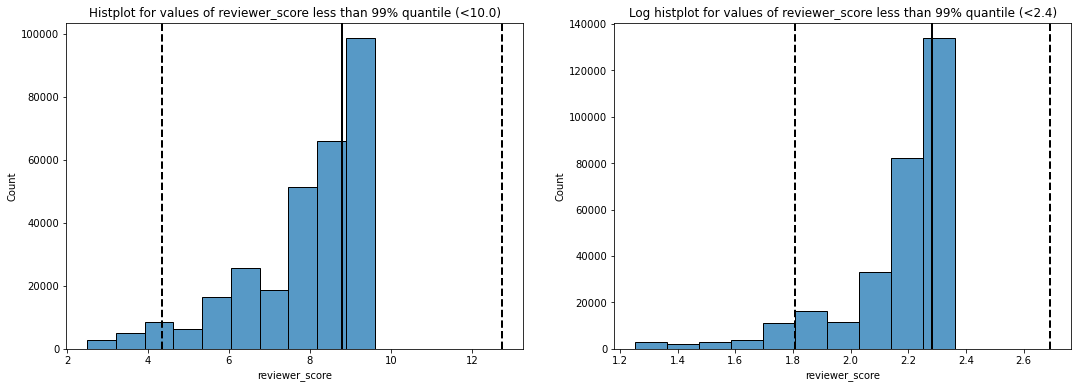

In [1326]:
get_number_column_info(hotels_train, 'reviewer_score')

In [1327]:
# Медиана больше среднего. Посмотрим отзывы с минимальной оценкой
mask = hotels_train['reviewer_score'] == hotels_train['reviewer_score'].min()
n_min = hotels_train[mask].shape[0]
print(f'Количество отзывов с минимальной оценкой: {n_min}')
hotels_train[mask].head(5)

Количество отзывов с минимальной оценкой: 1632


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
122,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,86,8/26/2016,8.3,Austria Trend Hotel Schloss Wilhelminenberg Wien,United States of America,Not much,3,1558,Bugs in our room Bad Wifi,7,3,2.5,"[' Leisure trip ', ' Couple ', ' Classic Room ...",342 day,NaN,NaN,train
267,49 53 New Road Tower Hamlets London E1 1HH Uni...,187,12/6/2015,7.6,The Whitechapel,United Kingdom,Everything It s a dry hotel If you are a devo...,63,830,Nothing Awful place It s aimed at Muslim trav...,44,8,2.5,"[' Business trip ', ' Solo traveler ', ' Execu...",606 day,51.516129,-0.062446,train
915,30 Jamestown Road Camden London NW1 7BY United...,418,11/16/2015,8.6,Holiday Inn London Camden Lock,France,This was booked as business trip for a collea...,248,1572,No Positive,0,1,2.5,"[' Business trip ', ' Solo traveler ', ' Doubl...",626 day,51.540456,-0.146083,train
1158,Via della Giustizia 10 D Bicocca Zara 20125 Mi...,221,8/23/2016,7.5,IH Hotels Milano Gioia,Switzerland,Very very poor internet Connection Horrible L...,15,3811,Sorry nothing,4,1,2.5,"[' Leisure trip ', ' Family with young childre...",345 day,45.499520,9.206138,train
1596,Leeuwendalersweg 21 Bos en Lommer 1055 JE Amst...,587,6/28/2016,7.4,Best Western Blue Tower Hotel,United Kingdom,location is not very good very little breakfa...,33,3869,maybe just reception and free printing option,8,13,2.5,"[' Leisure trip ', ' Couple ', ' Standard Doub...",401 day,52.379366,4.845718,train


В отзывах с минимальной оценкой видно, что даже в колонке с позитивными чертами люди пишут негатив. Также путают местами позитивные и негативные колонки.

Column average_score
Median 8.4 
Mean 8.4
Minimum 5.2
Maximum 9.8
--------------------
Number of zero values is 0
--------------------
Q25 = 8.1, Q75 = 8.8, IQR = 0.7000000000000011
Q25 - 1.5*IQR = 7.049999999999998
Q75 + 1.5*IQR = 9.850000000000001
--------------------


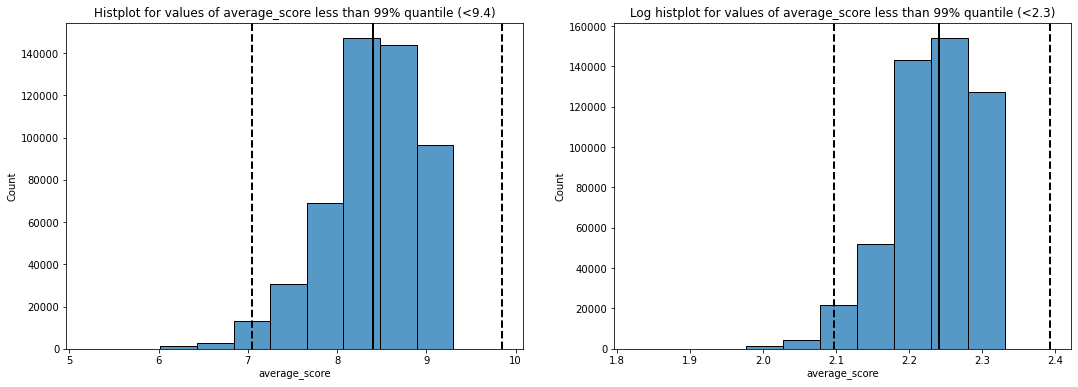

In [1328]:
get_number_column_info(hotels_total, 'average_score')

Column additional_number_of_scoring
Median 341.0 
Mean 498.1
Minimum 1.0
Maximum 2682.0
--------------------
Number of zero values is 0
--------------------
Q25 = 169.0, Q75 = 660.0, IQR = 491.0
Q25 - 1.5*IQR = -567.5
Q75 + 1.5*IQR = 1396.5
--------------------


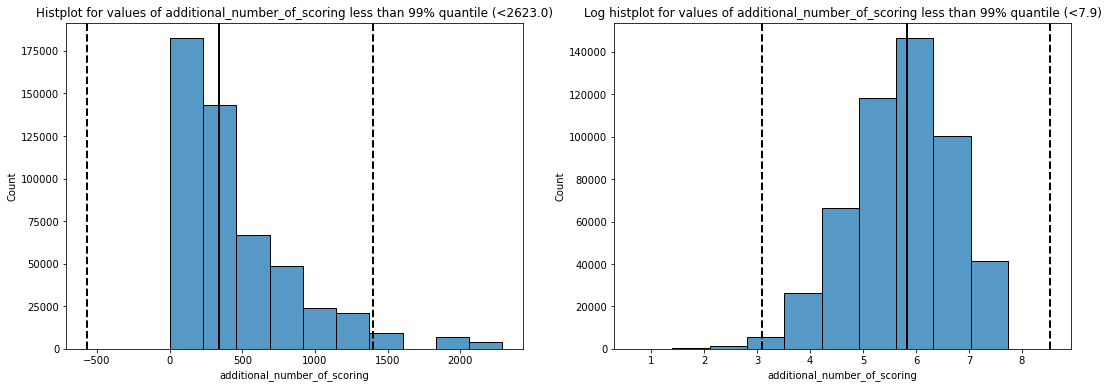

In [1329]:
get_number_column_info(hotels_total, 'additional_number_of_scoring')

Column total_number_of_reviews_reviewer_has_given
Median 3.0 
Mean 7.2
Minimum 1.0
Maximum 355.0
--------------------
Number of zero values is 0
--------------------
Q25 = 1.0, Q75 = 8.0, IQR = 7.0
Q25 - 1.5*IQR = -9.5
Q75 + 1.5*IQR = 18.5
--------------------


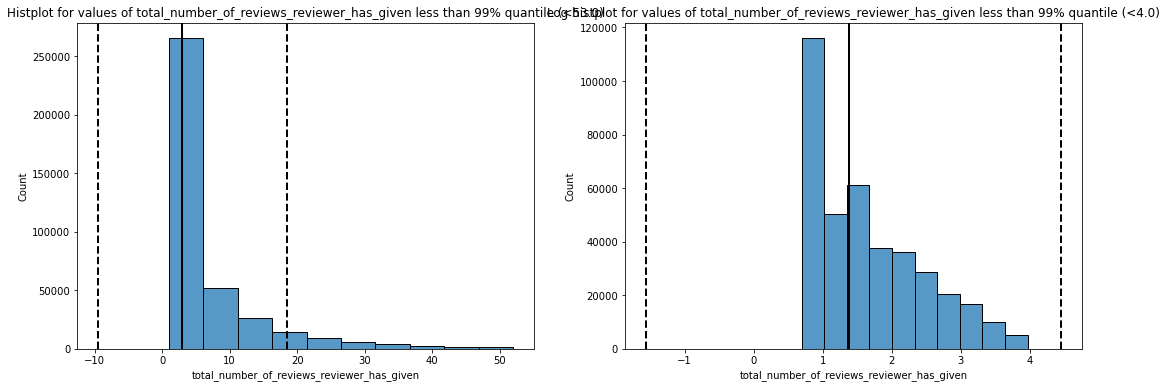

In [1330]:
get_number_column_info(hotels_train, 'total_number_of_reviews_reviewer_has_given')

Column review_day
Median 353.0 
Mean 354.4
Minimum 0.0
Maximum 730.0
--------------------
Number of zero values is 855
--------------------
Q25 = 175.0, Q75 = 527.0, IQR = 352.0
Q25 - 1.5*IQR = -353.0
Q75 + 1.5*IQR = 1055.0
--------------------


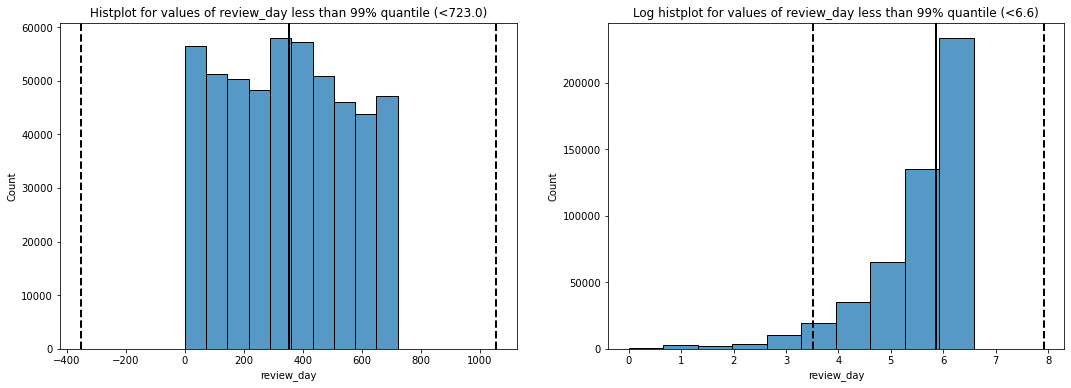

In [1331]:
get_number_column_info(hotels_total, 'review_day')

****

#### ПОДГОТОВКА ПРИЗНАКОВ

In [1332]:
# Проверим, остались ли у нас не числовые колонки и сколько всего признаков получилось
print(f'Нечисловые колонки: {hotels_total.select_dtypes(exclude="number").columns}')
print(f'Всего признаков: {hotels_total.shape[1] - 2}') # вычитаем 2 (целевой признак и добавленыый признак sample)
print(f'Перечень всех признаков: {hotels_total.columns}') 

Нечисловые колонки: Index(['sample'], dtype='object')
Всего признаков: 35
Перечень всех признаков: Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'sample', 'is_country_unitedkingdom', 'is_country_france',
       'is_country_netherlands', 'is_country_italy', 'is_country_austria',
       'is_country_spain', 'distance_to_center', 'network', 'is_local',
       'is_nationality_uk', 'no_positive', 'no_negative', 'pos_neg_diff',
       'was_great', 'neg_compound_score', 'pos_compound_score',
       'pos_neg_compound_diff', 'is_tags_leisuretrip',
       'is_tags_submittedfromamobiledevice', 'is_tags_couple',
       'is_tags_stayed1night', 'is_tags_stayed2nights', 'is_tags_solotraveler',
       'is_tags_stayed3nights', 'is_tags_businesstrip', 'is_tags_group',
       'is_tags_familywithyoungchildr

In [1333]:
# Делаем копию

hotels_total_copy = hotels_total.copy()

In [1334]:

hotels_total = hotels_total_copy.copy()

##### ТЕСТ НА МУЛЬТИКОЛЛИНЕАРНОСТЬ

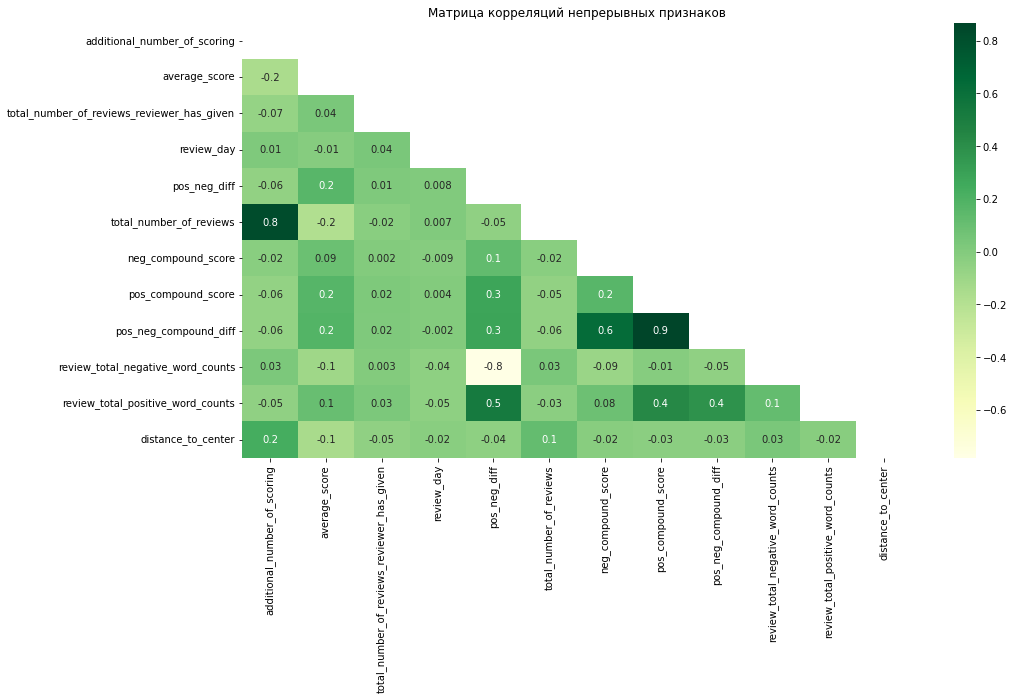

In [1335]:
# НЕПРЕРЫВНЫЕ ПЕРЕМЕННЫЕ
number_cols = [
    'additional_number_of_scoring', 'average_score' ,
    'total_number_of_reviews_reviewer_has_given' ,'review_day' , 
    'pos_neg_diff' , 'total_number_of_reviews', 
    'neg_compound_score', 'pos_compound_score',
    'pos_neg_compound_diff', 'review_total_negative_word_counts' ,
    'review_total_positive_word_counts', 'distance_to_center']

fig, axes = plt.subplots(figsize=(15,8))
corr_matrix = hotels_total[number_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    data = corr_matrix,
    annot=True,
    mask = mask,
    ax = axes,
    cmap = 'YlGn',
    fmt='.1g'
   )
axes.set_title('Матрица корреляций непрерывных признаков');


Видна сильная зависимость между total_number_of_reviews и additional_number_of_scoring 

In [1336]:
# Исключаем признаки, имеющие сильные корреляции
cols_to_drop = ['total_number_of_reviews', 'review_total_negative_word_counts', 'pos_neg_compound_diff']
hotels_total = hotels_total.drop(cols_to_drop, axis = 1) 

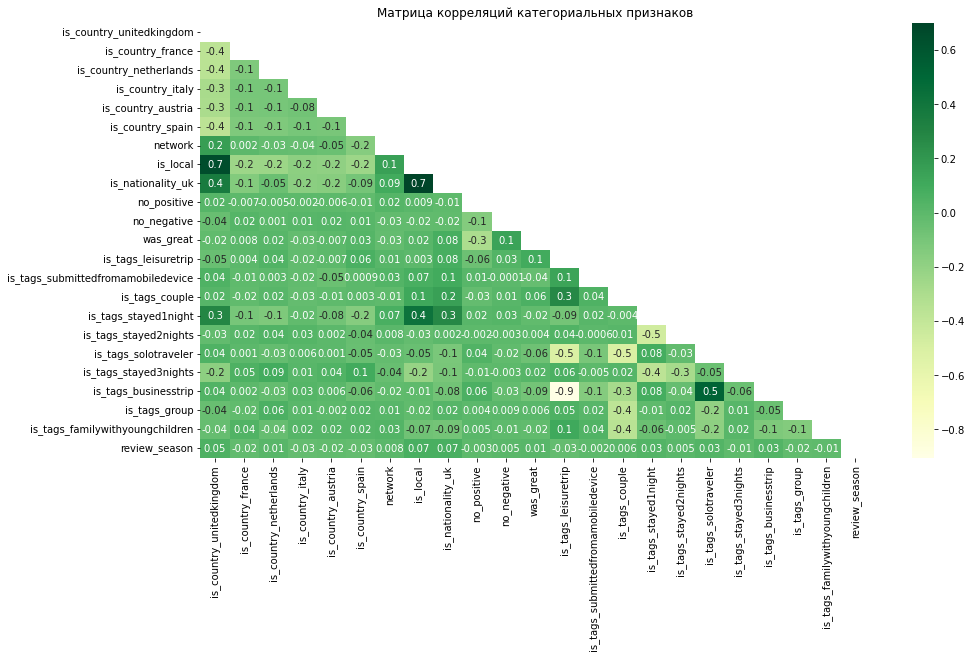

In [1337]:
# КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ
all_cols = hotels_total.select_dtypes(include="number").columns
cat_cols = list(filter(lambda x: x not in number_cols, all_cols))
cat_cols.remove('reviewer_score')

fig, axes = plt.subplots(figsize=(15,8))
corr_matrix = hotels_total[cat_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    data = corr_matrix,
    annot=True,
    mask = mask,
    ax = axes,
    cmap = 'YlGn',
    fmt='.1g'
   )
axes.set_title('Матрица корреляций категориальных признаков');

Видна сильная отрицательная корреляция между is_tags_businesstrip и is_tags_leisuretrip

In [1338]:
# Исключаем признаки, имеющие сильные корреляции
cols_to_drop = ['is_tags_businesstrip']
hotels_total = hotels_total.drop(cols_to_drop, axis = 1) 

****

##### СТАНДАРТИЗАЦИЯ

In [1339]:
# инициализируем нормализатор 
scaler = preprocessing.MinMaxScaler()

# Сформируем список колонок для нормализации
cols_to_normalize = list()
for col in hotels_total.columns:
    if col != target_name and col != 'sample':
        if hotels_total[col].min() < 0 or hotels_total[col].max() > 1:
            cols_to_normalize.append(col)
            
print(f'Столбцы для нормализации: {cols_to_normalize}')

other_cols = list(filter(lambda x: x not in cols_to_normalize, hotels_total.columns))

hotels_normalized = scaler.fit_transform(hotels_total[cols_to_normalize])
hotels_normalized = pd.DataFrame(hotels_normalized, columns=cols_to_normalize)

other_df = hotels_total[other_cols].copy()
other_df = other_df.reset_index() # После перестроения индекса старый индекс сохранится в колонке index
hotels_normalized = pd.concat([other_df, hotels_normalized], axis = 1)
hotels_normalized = hotels_normalized.set_index('index') # Восстанавливаем индекс
print(f'Размер датафрейма: {hotels_normalized.shape}')
display(hotels_normalized.head(3))


Столбцы для нормализации: ['additional_number_of_scoring', 'average_score', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'distance_to_center', 'pos_neg_diff', 'neg_compound_score', 'pos_compound_score', 'review_day']
Размер датафрейма: (515738, 33)


,reviewer_score,sample,is_country_unitedkingdom,is_country_france,is_country_netherlands,is_country_italy,is_country_austria,is_country_spain,network,is_local,...,review_season,additional_number_of_scoring,average_score,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,distance_to_center,pos_neg_diff,neg_compound_score,pos_compound_score,review_day
index,,,,,,,,,,,,,,,,,,,,,
0,10.0,train,1,0,0,0,0,0,0,1,...,1,0.216337,0.695652,0.007634,0.016949,0.063969,0.514066,0.500527,0.791515,0.727397
1,6.3,train,1,0,0,0,0,0,0,1,...,1,0.111153,0.673913,0.002545,0.036723,0.057727,0.510230,0.261495,0.495964,0.278082
2,7.5,train,0,1,0,0,0,0,0,0,...,0,0.011563,0.804348,0.000000,0.036723,0.058508,0.506394,0.352103,0.495964,0.395890


****

#### РАЗДЕЛЯЕМ ДАТАФРЕЙМ НА ТРЕНИРОВОЧНЫЙ И ТЕСТОВЫЙ

In [1340]:
train_df = hotels_normalized[hotels_normalized['sample'] == 'train'].copy()
test_df = hotels_normalized[hotels_normalized['sample'] == 'test'].copy()

train_df = train_df.drop('sample', axis = 1)
test_df = test_df.drop('sample', axis = 1)
test_df = test_df.drop(target_name, axis = 1)

x = train_df.drop(target_name, axis = 1)
y = train_df[target_name].copy()

#Проверка
print(f'Размер тренировочного датафрейма: {train_df.shape}')
print(f'Размер тестового датафрейма: {test_df.shape}')

Размер тренировочного датафрейма: (386803, 32)
Размер тестового датафрейма: (128935, 31)


##### ОЦЕНКА ЗНАЧИМОСТИ

<AxesSubplot:>

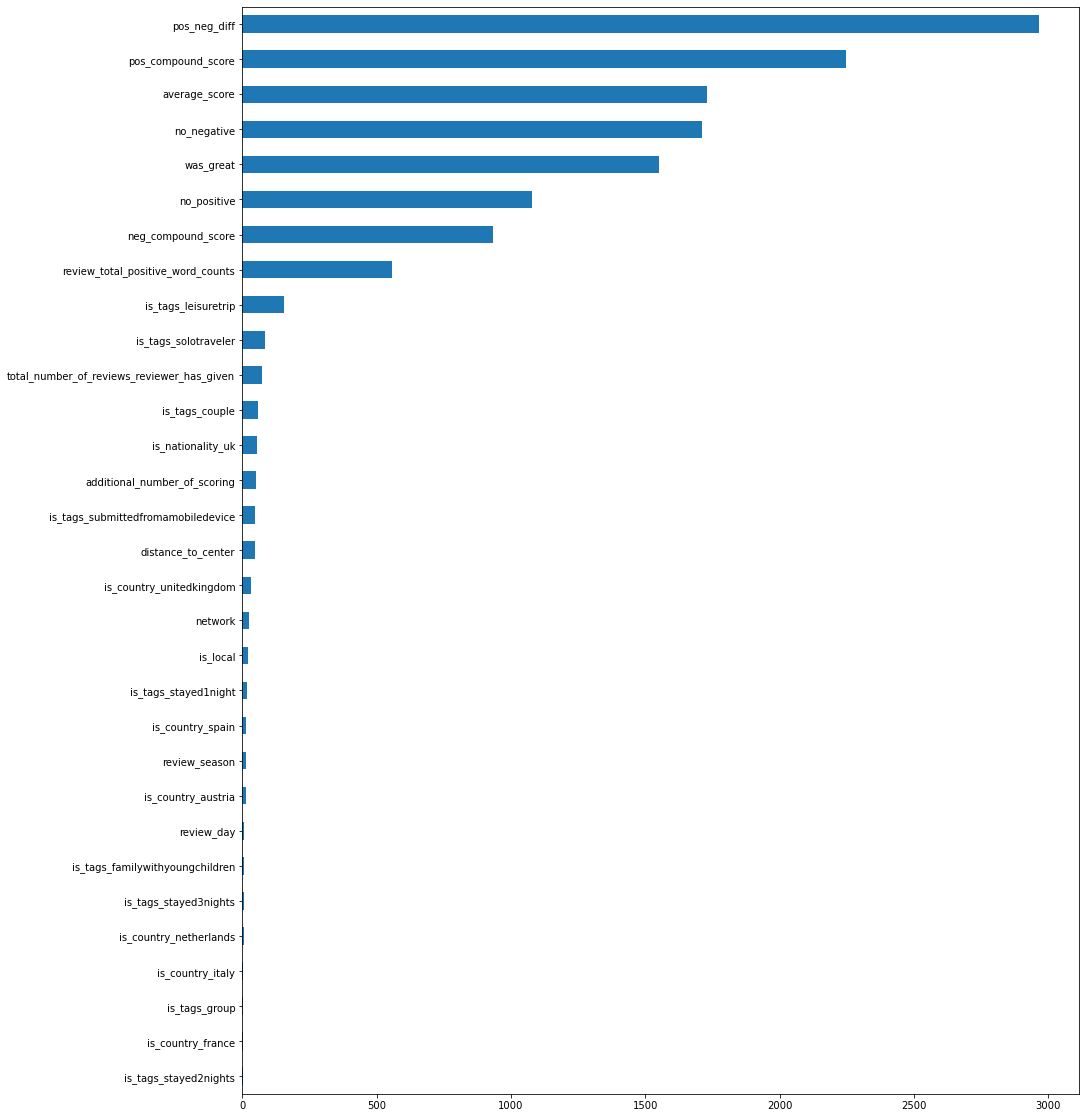

In [1341]:
# Применяем ANOVA метод
imp_features = pd.Series(f_classif(x, y)[0], index=x.columns)
imp_features.sort_values(inplace = True)
fig, axes = plt.subplots(figsize=(15, 20))
imp_features.plot(kind = 'barh')

In [1342]:
# Удаляем незначимые признаки 

cols_to_drop = imp_features[imp_features < 10].index
print(f'Незначимые признаки: {cols_to_drop}')

x = x.drop(cols_to_drop, axis = 1)
test_df = test_df.drop(cols_to_drop, axis = 1)  
      
      

Незначимые признаки: Index(['is_tags_stayed2nights', 'is_country_france', 'is_tags_group',
       'is_country_italy', 'is_country_netherlands', 'is_tags_stayed3nights',
       'is_tags_familywithyoungchildren', 'review_day'],
      dtype='object')


****

##### ОБУЧЕНИЕ МОДЕЛИ

In [1343]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.

test_share = 0.25
random_seed = 42
  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_share, random_state=random_seed)

In [1344]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(x_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(x_test) 

In [1345]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12556165284325116


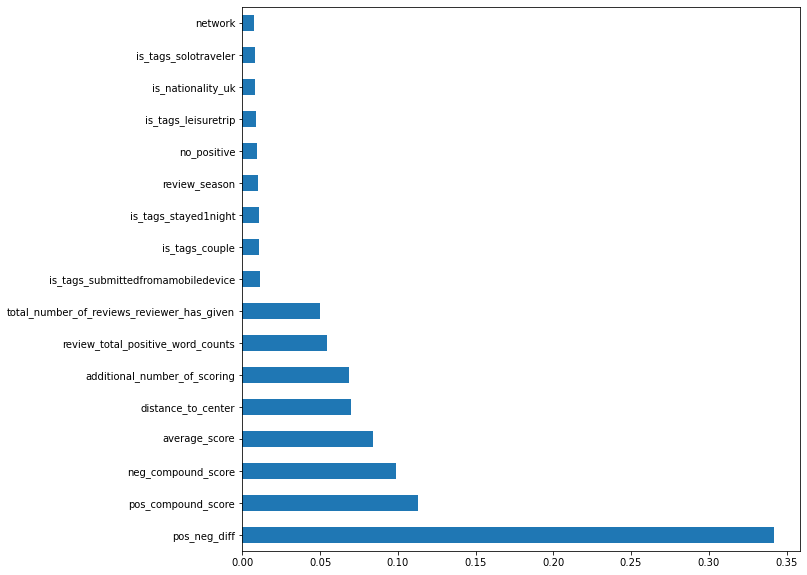

In [1346]:
# Выводим самые важные признаки
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=x.columns)
feat_importances.nlargest(17).plot(kind='barh');

****

#### ПРЕДСКАЗАНИЕ ЦЕЛЕВОГО ПРИЗНАКА

In [1347]:
test_predict = regr.predict(test_df)
submission['reviewer_score'] = test_predict

submission.to_csv('submission9.csv', index=False)
submission.head()

,reviewer_score,id
0,8.740,488440
1,7.365,274649
2,8.514,374688
3,9.680,404352
4,9.473,451596


In [1348]:
print('Модель рассчитана')

Модель рассчитана
